# Notebook for running makeBrighterFatterKernel.py on BOT data.

Initially written 17 Dec 2019 by Craig Lage. (Originally using)
lsst_distrib          19.0.0+58  	current w_2020_09 setup


In [1]:
! eups list -s | grep lsst_distrib
! eups list -s obs_lsst
! eups list -s cp_pipe

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_21/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/eups 	setup
lsst_distrib          21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup
   21.0.0-39-g1bb8220+1cffe0d522 	current w_2021_21 d_latest d_2021_05_19 w_latest setup
   21.0.0-24-g07df93d+ba9361c0b3 	w_latest w_2021_21 current setup


Next, I generate the calibration files for run 12781 and generate the BF kernels. 
This can be done in the notebook or command line.

```
# Flats
! pipetask run -j 9 -d "instrument='LSSTCam' AND exposure.science_program IN ('12781') AND detector in ( 28, 29, 96 ) AND exposure.observation_type = 'flat' AND exposure.observation_reason='sflat' " -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781 -o u/abrought/run_12781/bf_work/flats -p /u/gu/abrought/cp_pipe/pipelines/cpFlat.yaml --register-dataset-types > flat_output1.log
    
# Certify flats
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/abrought/run_12781/bf_work/flats/20210608T205612Z /calib/run_12781_v2 flat

# Certify bias
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/jchiang/calib/bias/run_12781/20210525T184949Z /calib/run_12781_v2 bias

# Certify dark
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/youtsumi/calib/dark/run_12781 /calib/run_12781_v2 dark

# Certify defects
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/youtsumi/calib/defects/run_12781 /calib/run_12781_v2 defects

# PTCs
pipetask run -j 9 -d "instrument='LSSTCam' AND exposure.science_program IN ('12781') AND detector in ( 28, 29, 96 ) AND exposure.observation_type = 'flat' AND exposure.observation_reason='flat' " -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781_v2 -o u/abrought/run_12781/bf_work/ptcs -p /u/gu/abrought/cp_pipe/pipelines/measurePhotonTransferCurve.yaml -c ptcSolve:ptcFitType=EXPAPPROXIMATION --register-dataset-types

# Certify PTCs
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/abrought/run_12781/bf_work/ptcs/20210608T230546Z /calib/run_12781_v2 ptc


# Generate BF Kernels
# You must only specify one exposure at a time, I selected the first in the sequence. This generated the kernel for the given detectors.
pipetask run -j 9 -d "instrument='LSSTCam' AND exposure IN (3020111900045) AND detector in ( 28, 29, 96 ) " -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/ -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781_v2  -o u/abrought/run_12781/bf_work/bfks -p /u/gu/abrought/cp_pipe/pipelines/cpBfkSolve.yaml --register-dataset-types

#Certify BF Kernels
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2 u/abrought/run_12781/bf_work/bfks/20210609T191428Z /calib/run_12781_v2 bfk
```




I will now load the BF Kernel for detectors 28 (itl), 29(itl), 96 (e2v)

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table


bfkdir = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/bfks/20210622T205451Z/bfk/"
bfkfiles = glob.glob(bfkdir + "*.fits")
print(bfkfiles)
hdu = fits.open(bfkfiles[0])

['/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/bfks/20210622T205451Z/bfk/bfk_LSSTCam_R10_S02_u_abrought_run_12781_bf_work_v5_polynomialfit_bfks_20210622T205451Z.fits', '/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/bfks/20210622T205451Z/bfk/bfk_LSSTCam_R10_S01_u_abrought_run_12781_bf_work_v5_polynomialfit_bfks_20210622T205451Z.fits', '/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/bfks/20210622T205451Z/bfk/bfk_LSSTCam_R22_S20_u_abrought_run_12781_bf_work_v5_polynomialfit_bfks_20210622T205451Z.fits']


In [2]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                23659 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    9 / number of table fields                         
TTYPE1  = 'AMPLIFIER'                                                           
TFORM1  = '3A      '                                                            
TTYPE2  = 'MEANS   '                                                            
TFORM2  = '36D     '                                                            
TDIM2   = '(36)    '        

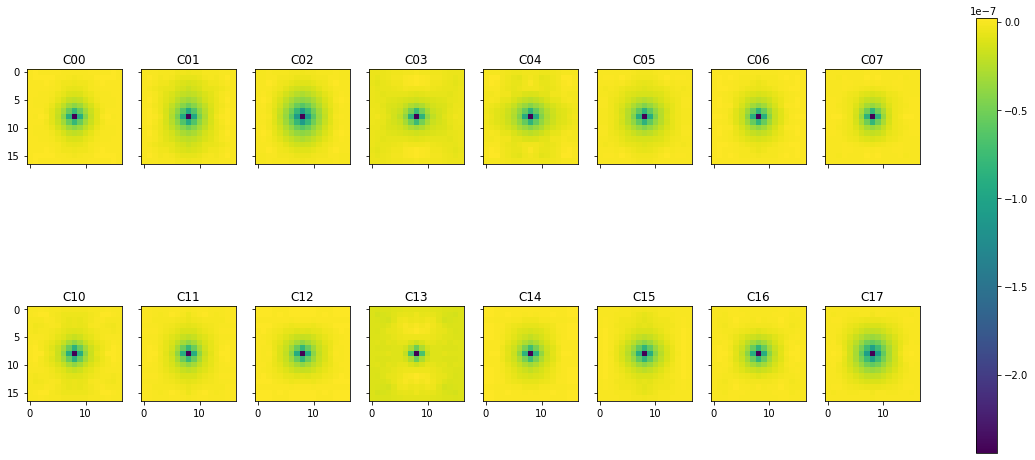

In [3]:
fig, axs = plt.subplots(2,8, sharex=True, sharey=True, squeeze=True, figsize=(20,8))
plt.title("Kernel profile for (R10_S02, itl)", fontsize="x-large")
for i, amp in enumerate(hdu[1].data):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.imshow(amp['KERNEL'].reshape(17,17))
    ax.set(title=amp['AMPLIFIER'])
cb = fig.colorbar(im, ax=axs.ravel().tolist())



In [4]:
import os, sys, time, datetime, glob, subprocess
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import astropy.io.fits as pf
from scipy import stats
from lsst.daf.persistence import Butler
from lsst.cp.pipe.makeBrighterFatterKernel import BrighterFatterKernelSolveTask

In [6]:
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler

raftName = 'R10'
detectorName = 'S02'
DETECTOR = 29

COLLECTION = 'u/abrought/run_12781/bf_work_v5/polynomialfit/bfks/20210622T205451Z'
REPO_DIR = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/'

In [7]:
# Now we can get the extracted covariances and kernels and plot them
bf_butler = Butler(REPO_DIR, collections=COLLECTION)
bf_kernel = bf_butler.get('bfk', dataId={'detector': DETECTOR})
data = bf_kernel.toDict()
data_table = bf_kernel.toTable()
data.keys()

dict_keys(['metadata', 'means', 'variances', 'rawXcorrs', 'badAmps', 'gain', 'noise', 'meanXcorrs', 'ampKernels', 'valid', 'detKernels'])

<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipython-input-8-e05a8da5c186>:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
<ipyth

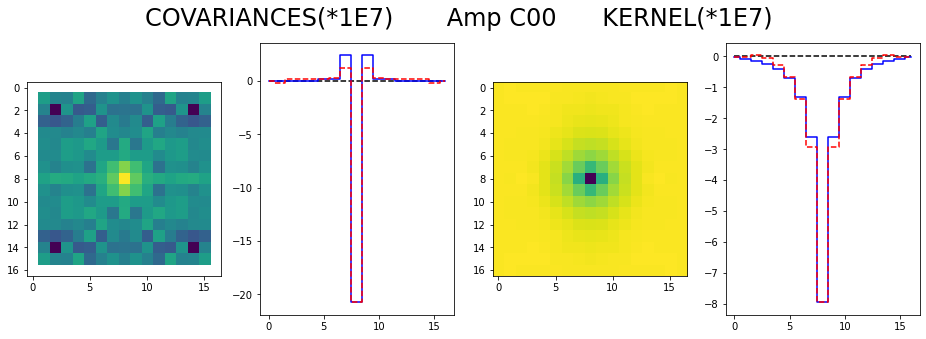

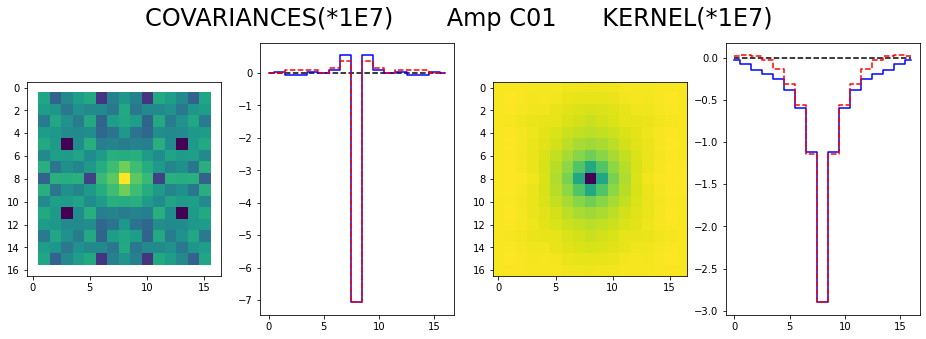

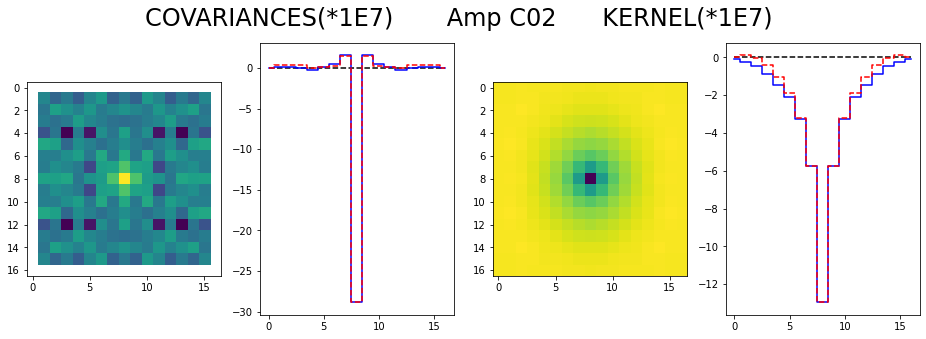

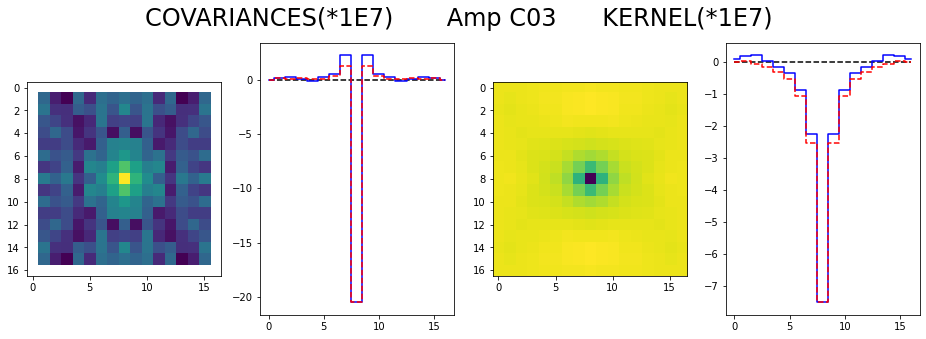

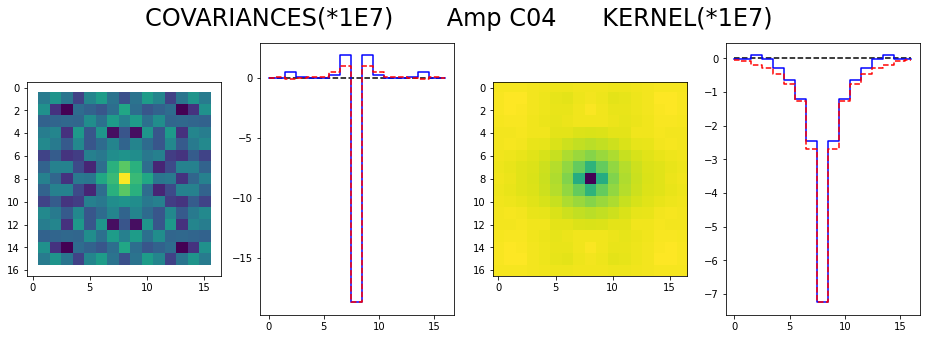

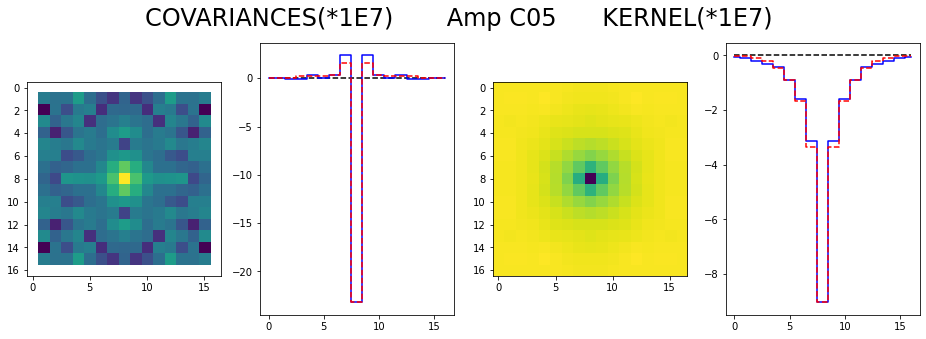

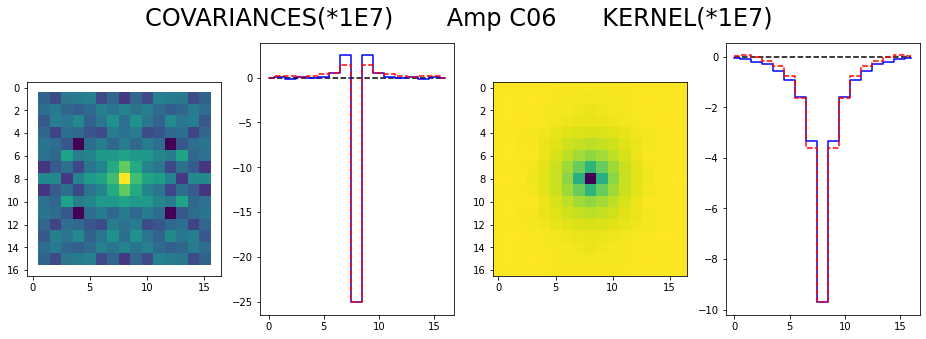

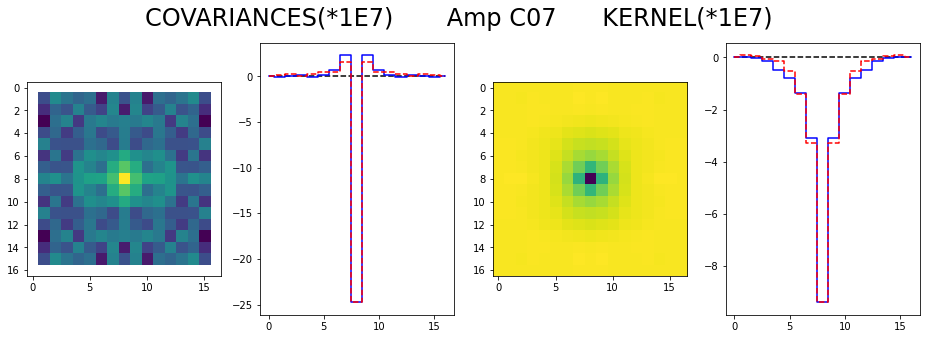

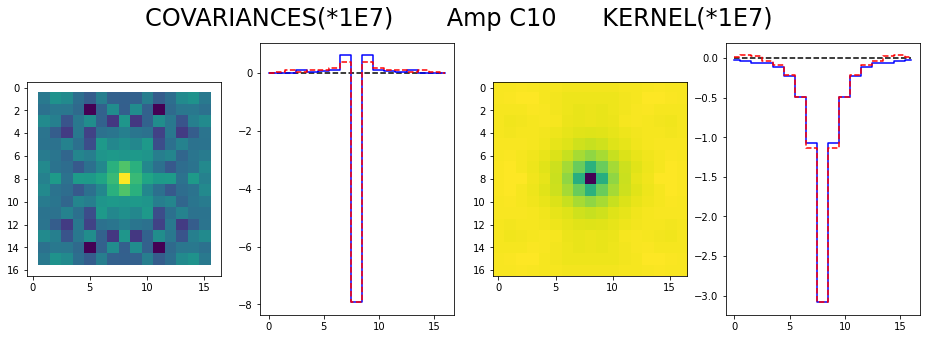

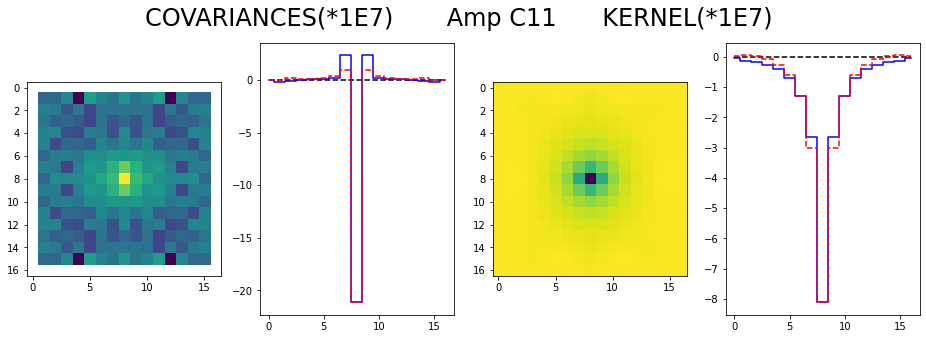

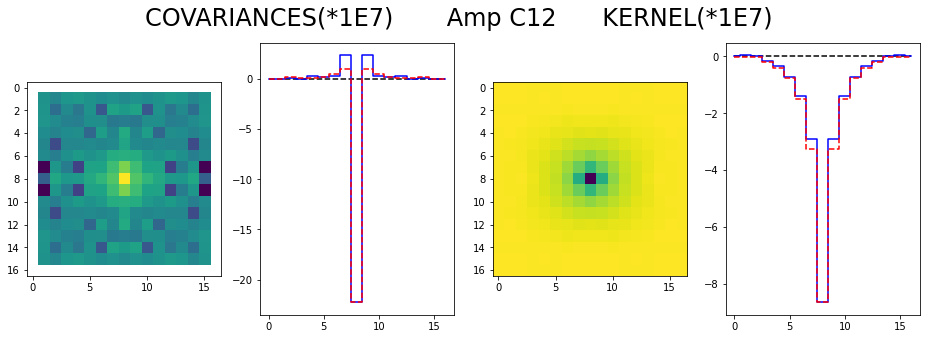

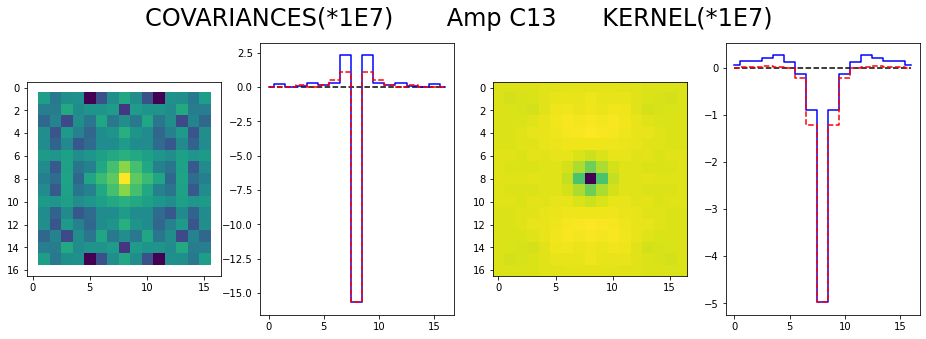

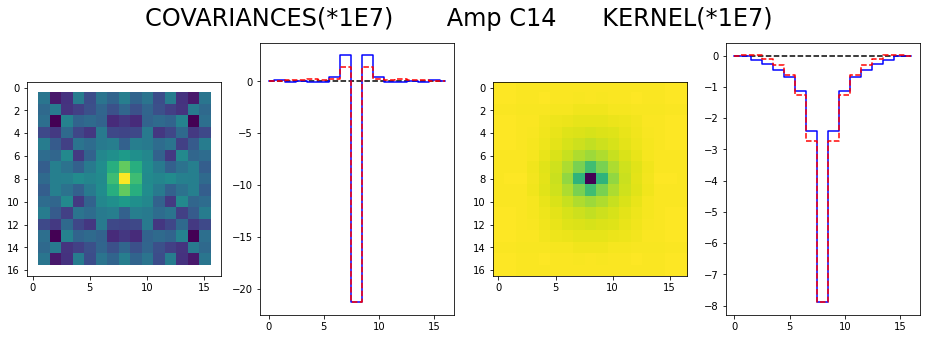

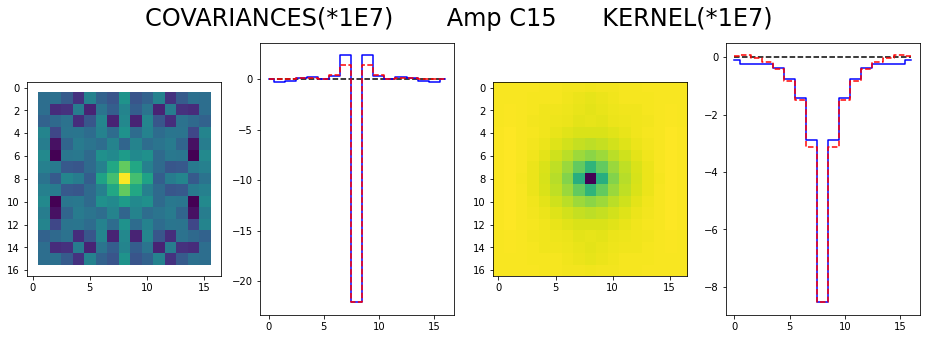

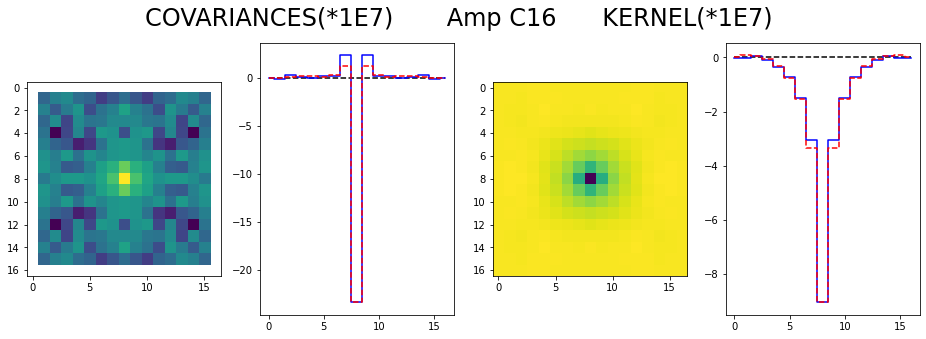

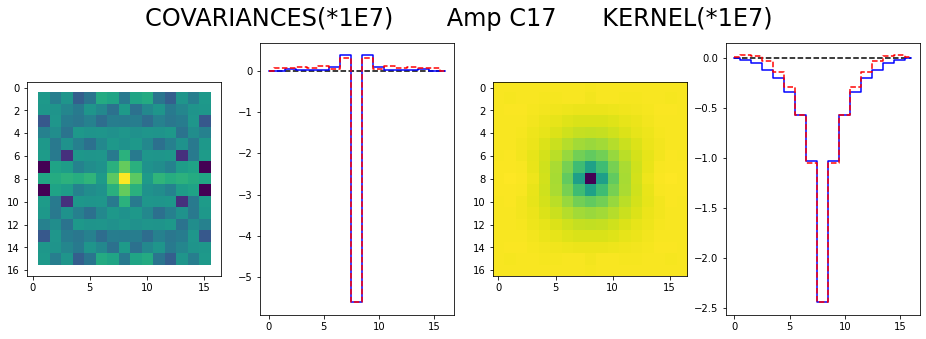

In [8]:
# Now plot the correlations and the kernel. 
from datetime import date
today = date.today()
date = today.strftime("%Y_%m_%d")

means=data['means']
meanXcorrs = data['meanXcorrs']
kernels = data['ampKernels']
for amp in kernels.keys():
    kernels[amp] = np.asarray(kernels[amp]).reshape(17,17)
    meanXcorrs[amp] = np.asarray(meanXcorrs[amp]).reshape(17,17)

pdf = PdfPages(os.path.curdir+"/plots/Corr_Kernel_Comparison_ITL_%s_%s.pdf"%(date,DETECTOR))
for amp in means.keys():
    fig = plt.figure(figsize=(16,5))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("COVARIANCES(*1E7)       Amp %s      KERNEL(*1E7)"%amp, fontsize=24)
    plt.subplot(1,4,1)
    plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
    plt.subplot(1,4,2)
    plt.plot([0,16],[0,0], ls='--', color='black')
    #plt.yticks([])  
    plt.plot(-meanXcorrs[amp][:,8]*1E7, color='blue', drawstyle='steps-mid')
    plt.plot(-meanXcorrs[amp][8,:]*1E7, linestyle='--', color='red', drawstyle='steps-mid')
    #plt.ylim(-40,10)
    plt.subplot(1,4,3)
    plt.imshow(kernels[amp])
    plt.subplot(1,4,4)  
    plt.plot([0,16],[0,0], ls='--', color='black')
    plt.plot(kernels[amp][:,8]*1E7, color='blue', drawstyle='steps-mid')
    plt.plot(kernels[amp][8,:]*1E7, linestyle='--', color='red', drawstyle='steps-mid')
    #plt.ylim(-10,2)
    pdf.savefig(fig)
pdf.close()

